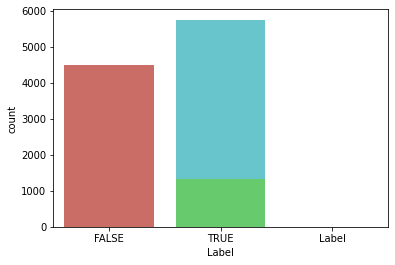

In [12]:

import pickle
import pandas as pd
import csv
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
from sklearn import svm
from sklearn.svm import SVC
from nltk.classify.scikitlearn import SklearnClassifier


test_filename = 'test.csv'
train_filename = 'train.csv'
valid_filename = 'valid.csv'

train_news = pd.read_csv(train_filename)
test_news = pd.read_csv(test_filename)
valid_news = pd.read_csv(valid_filename)



#data observation
def data_obs():
    print("training dataset size:")
    print(train_news.shape)
    print(train_news.head(10))


    print(test_news.shape)
    print(test_news.head(10))
    
    print(valid_news.shape)
    print(valid_news.head(10))


#distribution of classes for prediction
def create_distribution(dataFile):
    
    return sb.countplot(x='Label', data=dataFile, palette='hls')
    

#by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_news)
create_distribution(test_news)
create_distribution(valid_news)



eng_stemmer = SnowballStemmer('english')
stopwords = set(nltk.corpus.stopwords.words('english'))

#Stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

#process the data
def process_data(data,exclude_stopword=True,stem=True):
    tokens = [w.lower() for w in data]
    tokens_stemmed = tokens
    tokens_stemmed = stem_tokens(tokens, eng_stemmer)
    tokens_stemmed = [w for w in tokens_stemmed if w not in stopwords ]
    return tokens_stemmed


#creating ngrams
#unigram 
def create_unigram(words):
    assert type(words) == list
    return words


def create_bigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 1:
        lst = []
        for i in range(Len-1):
            for k in range(1,skip+2):
                if i+k < Len:
                    lst.append(join_str.join([words[i],words[i+k]]))
    else:
        #set it as unigram
        lst = create_unigram(words)
    return lst

def create_trigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 2:
        lst = []
        for i in range(1,skip+2):
            for k1 in range(1, skip+2):
                for k2 in range(1,skip+2):
                    if i+k1 < Len and i+k1+k2 < Len:
                        lst.append(join_str.join([words[i], words[i+k1],words[i+k1+k2]]))
                      
        else:
           lst = create_bigrams(words)
        return lst
 




porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]





In [13]:



#create tf-df frequency features
#tf-idf 
countV = CountVectorizer()
train_count = countV.fit_transform(train_news['Statement'].values)
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

def get_tfidf_stats():
    train_tfidf.shape
    #get train data feature names 
    print(train_tfidf.A[:10])






In [14]:


from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score




def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y = train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    return (print('Total statements classified:', len(train_news)),
    print('Score:', sum(scores)/len(scores)),
    print('score length', len(scores)))
   
    


tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,3),use_idf=True,smooth_idf=True)


#linear SVM classifier
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',SVC(probability = True))
        ])


svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])


build_confusion_matrix(svm_pipeline_ngram)


model_file = 'final_model.sav'



Total statements classified: 10240
Score: 0.7129318031258836
score length 5


In [21]:
var = "Obama is dumb."
pickle.dump(svm_pipeline_ngram,open(model_file,'wb')) 
load_model = pickle.load(open('final_model.sav', 'rb'))
prediction = load_model.predict([var])
prob = load_model.predict_proba([var])


print("The given statement is ",prediction[0])
print("The probability score is ",prob[0][1])





The given statement is  False
The probability score is  0.07668965628647834
